In [1]:
# data augmentation only

In [2]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from keras import models
import numpy as np
tf.__version__

'2.18.0'

In [3]:
import os
import zipfile

local_zip = '/tmp/image_scene.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/image_scene')
zip_ref.close()

In [4]:
base_dir = '/tmp/image_scene'

#train directories
train_dir = os.path.join(base_dir, 'seg_train/seg_train')
test_dir = os.path.join(base_dir, 'seg_test/seg_test')

In [5]:
import shutil

# create directories for partial train and test data (images/category)

categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
num_images = 350
partial_train_dir = '/tmp/partial_train'
partial_test_dir = '/tmp/partial_test'

os.makedirs(partial_train_dir, exist_ok=True)
os.makedirs(partial_test_dir, exist_ok=True)

In [6]:
# copy images from each category to 'partial...' directives
def reduce_data(input_dir, output_dir):
  for category in categories:
    category_dir = os.path.join(input_dir, category)
    output_category_dir = os.path.join(output_dir, category)
    os.makedirs(output_category_dir, exist_ok=True)

    image_files = os.listdir(category_dir)[:num_images]
    for image_file in image_files:
      source_path = os.path.join(category_dir, image_file)
      dst_path = os.path.join(output_category_dir, image_file)
      shutil.copy(source_path, dst_path)

reduce_data(train_dir, partial_train_dir)
reduce_data(test_dir, partial_test_dir)

In [7]:
# initilaizing training arrays
train_images = []
train_labels = []

In [8]:
import numpy as np

# only for training data
# combine all subpaths to one
# so that later we can use flow_from_dataframe
def combining_paths(input_dir, features_array, labels_array):
  for category in categories:
    category_dir = os.path.join(input_dir, category)
    for fname in os.listdir(category_dir):
      features_array.append(os.path.join(category_dir, fname))
      labels_array.append(category)

combining_paths(partial_train_dir, train_images, train_labels)

# will use flow from directory for test data

In [9]:
# convert all training arrays to numpy arrays (dataframe) of images
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [10]:
from keras import layers
from keras import models
from keras import optimizers
model = 0

#network

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=['acc'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# OPTION A: data augmentation only

In [12]:
#data augmentaion only for training data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

#validation and test
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
from keras import layers
from keras import optimizers
from sklearn.model_selection import KFold
import pandas as pd

k=4
kf = KFold(n_splits=k, shuffle=True, random_state=42)
all_scores=[]
num_epochs = 30
batch_size = 35

train_acc = []
val_acc =  []
train_loss = []
val_loss = []

In [14]:
test_generator = test_datagen.flow_from_directory(
    partial_test_dir,
    target_size=(150,150),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 2081 images belonging to 6 classes.


In [15]:
for fold, (train_idx, val_idx) in enumerate(kf.split(train_images)):
  print(f'\nProcessing fold # {fold+1}/{k} ###########################')

  #split train_images dataframe into train and val
  train_x, val_x = train_images[train_idx], train_images[val_idx]
  train_y, val_y = train_labels[train_idx], train_labels[val_idx]

  # train generator use flow from dataframe
  train_generator = train_datagen.flow_from_dataframe(
    dataframe = pd.DataFrame({'filename': train_x, 'class': train_y}),
    x_col = 'filename',
    y_col = 'class',
    target_size = (150,150),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=True)

    # val generator use flow from dataframe
  val_generator = val_datagen.flow_from_dataframe(
      dataframe = pd.DataFrame({'filename': val_x, 'class': val_y}),
      x_col = 'filename',
      y_col = 'class',
      target_size = (150,150),
      batch_size = batch_size,
      class_mode = 'categorical',
      shuffle = True
  )

  history = model.fit(
    train_generator,
    steps_per_epoch = 80, #2100 images = batch size * steps (60)
    epochs=num_epochs,
    validation_data=val_generator,
    validation_steps = 80)

  train_acc.append(history.history['acc'])
  val_acc.append(history.history['val_acc'])
  train_loss.append(history.history['loss'])
  val_loss.append(history.history['val_loss'])


Processing fold # 1/4 ###########################
Found 1575 validated image filenames belonging to 6 classes.
Found 525 validated image filenames belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
45/80 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step - acc: 0.2255 - loss: 1.7378

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


80/80 ━━━━━━━━━━━━━━━━━━━━ 22s 143ms/step - acc: 0.2582 - loss: 1.6950 - val_acc: 0.3238 - val_loss: 1.6157
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - acc: 0.4065 - loss: 1.4228 - val_acc: 0.4819 - val_loss: 1.2665
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - acc: 0.4488 - loss: 1.3227 - val_acc: 0.4743 - val_loss: 1.2220
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - acc: 0.4814 - loss: 1.2894 - val_acc: 0.4914 - val_loss: 1.2004
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - acc: 0.4973 - loss: 1.1927 - val_acc: 0.4990 - val_loss: 1.1501
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - acc: 0.5039 - loss: 1.2093 - val_acc: 0.5352 - val_loss: 1.0727
Epoch 7/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - acc: 0.5295 - loss: 1.1440 - val_acc: 0.4933 - val_loss: 1.1175
Epoch 8/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - acc: 0.5372 - loss: 1.1378 - val_acc: 0.5867 - val_loss: 0.9699
Epoch 9/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - acc:

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
45/80 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step - acc: 0.7273 - loss: 0.6893

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - acc: 0.7197 - loss: 0.7166 - val_acc: 0.7410 - val_loss: 0.6560
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - acc: 0.7092 - loss: 0.7651 - val_acc: 0.7790 - val_loss: 0.5985
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - acc: 0.7370 - loss: 0.7198 - val_acc: 0.7371 - val_loss: 0.6523
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - acc: 0.7358 - loss: 0.7506 - val_acc: 0.7524 - val_loss: 0.6391
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - acc: 0.7427 - loss: 0.6934 - val_acc: 0.7619 - val_loss: 0.6310
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - acc: 0.7239 - loss: 0.7245 - val_acc: 0.7448 - val_loss: 0.6365
Epoch 7/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - acc: 0.7574 - loss: 0.6478 - val_acc: 0.7314 - val_loss: 0.7041
Epoch 8/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - acc: 0.7476 - loss: 0.6733 - val_acc: 0.7524 - val_loss: 0.6504
Epoch 9/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - acc:

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
45/80 ━━━━━━━━━━━━━━━━━━━━ 7s 217ms/step - acc: 0.7860 - loss: 0.5941

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - acc: 0.7841 - loss: 0.6019 - val_acc: 0.8552 - val_loss: 0.4209
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - acc: 0.7705 - loss: 0.6011 - val_acc: 0.7829 - val_loss: 0.5336
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - acc: 0.7894 - loss: 0.5546 - val_acc: 0.7752 - val_loss: 0.5853
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - acc: 0.7970 - loss: 0.5476 - val_acc: 0.8610 - val_loss: 0.3972
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - acc: 0.7909 - loss: 0.5474 - val_acc: 0.8038 - val_loss: 0.4746
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - acc: 0.7858 - loss: 0.5759 - val_acc: 0.8533 - val_loss: 0.4066
Epoch 7/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - acc: 0.8198 - loss: 0.4813 - val_acc: 0.8514 - val_loss: 0.3868
Epoch 8/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - acc: 0.7948 - loss: 0.5292 - val_acc: 0.8533 - val_loss: 0.4194
Epoch 9/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - acc:

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
45/80 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step - acc: 0.8281 - loss: 0.4333

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - acc: 0.8239 - loss: 0.4473 - val_acc: 0.8552 - val_loss: 0.3626
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - acc: 0.8339 - loss: 0.4429 - val_acc: 0.8933 - val_loss: 0.2831
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - acc: 0.8461 - loss: 0.4108 - val_acc: 0.9105 - val_loss: 0.2733
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - acc: 0.8373 - loss: 0.4376 - val_acc: 0.8971 - val_loss: 0.3164
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - acc: 0.8329 - loss: 0.4181 - val_acc: 0.8762 - val_loss: 0.3235
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - acc: 0.8469 - loss: 0.4008 - val_acc: 0.8876 - val_loss: 0.3182
Epoch 7/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - acc: 0.8416 - loss: 0.4055 - val_acc: 0.8686 - val_loss: 0.4096
Epoch 8/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - acc: 0.8410 - loss: 0.4062 - val_acc: 0.8895 - val_loss: 0.3331
Epoch 9/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - acc:

In [16]:
test_loss, test_acc = model.evaluate(test_generator, verbose=1)

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - acc: 0.8084 - loss: 0.6166


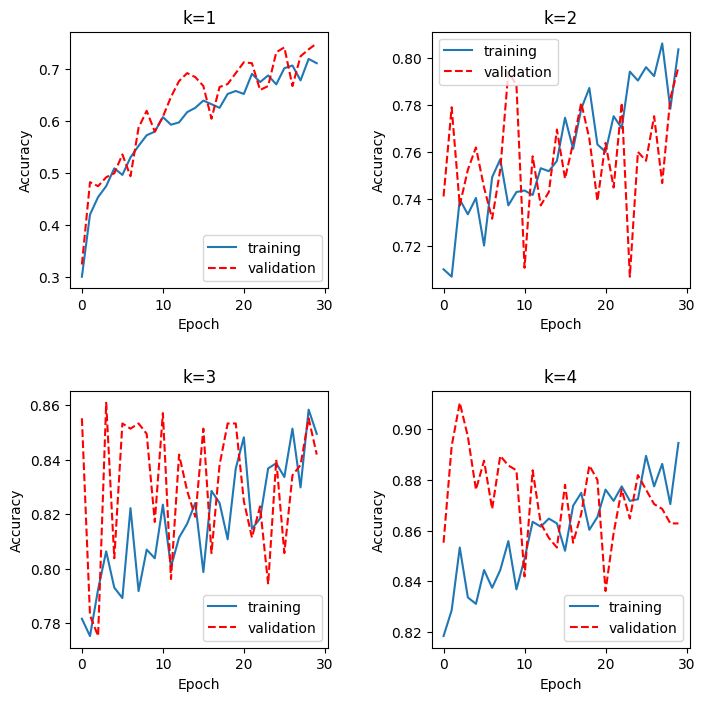

In [17]:
import matplotlib.pyplot as plt

# Cross fold 0
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
fig.subplots_adjust(wspace=0.4, hspace=0.4)

axs[0, 0].plot(np.arange(num_epochs), train_acc[0], label='training')
axs[0, 0].plot(np.arange(num_epochs), val_acc[0], 'r--', label='validation')
axs[0, 0].set_title("k=1")
axs[0, 0].set(xlabel='Epoch', ylabel='Accuracy')
axs[0, 0].legend()

# Cross fold 1
axs[0, 1].plot(np.arange(num_epochs), train_acc[1], label='training')
axs[0, 1].plot(np.arange(num_epochs), val_acc[1], 'r--', label='validation')
axs[0, 1].set_title("k=2")
axs[0, 1].set(xlabel='Epoch', ylabel='Accuracy')
axs[0, 1].legend()

# Cross fold 2
axs[1, 0].plot(np.arange(num_epochs), train_acc[2], label='training')
axs[1, 0].plot(np.arange(num_epochs), val_acc[2], 'r--', label='validation')
axs[1, 0].set_title("k=3")
axs[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
axs[1, 0].legend()

# Cross fold 3
axs[1, 1].plot(np.arange(num_epochs), train_acc[3], label='training')
axs[1, 1].plot(np.arange(num_epochs), val_acc[3], 'r--', label='validation')
axs[1, 1].set_title("k=4")
axs[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
axs[1, 1].legend()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 864ms/step


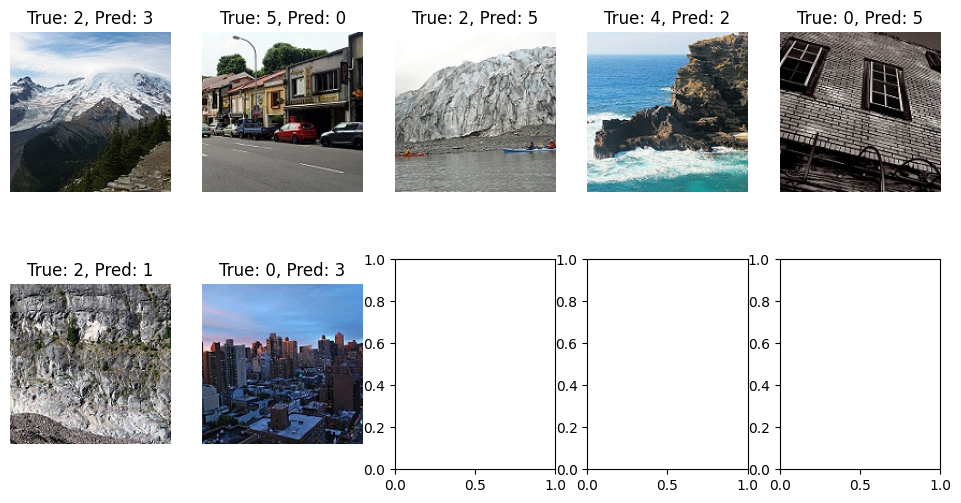

In [18]:
# Get predictions on validation set
test_images, test_labels = next(test_generator)  # Get a batch
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Identify misclassified samples
misclassified_indices = np.where(predicted_classes != true_classes)[0]

# Display a few misclassified images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, idx in enumerate(misclassified_indices[:10]):
    axes[i // 5, i % 5].imshow(test_images[idx])
    axes[i // 5, i % 5].set_title(f'True: {true_classes[idx]}, Pred: {predicted_classes[idx]}')
    axes[i // 5, i % 5].axis('off')

plt.show()